# ViT Prototype: RGB Hilbert 32x32 Network Payload Classification (Few-Shot Holdout)

**Objective:** Evaluate Vision Transformer performance on RGB Hilbert curve 32x32 image representations of network payloads, preserving a few-shot holdout of 3 classes.

## Overview

This notebook adapts the ViT prototype for **RGB Hilbert curve 32x32 images** from the local parquet dataset, enabling direct comparison with other encoding strategies. The Hilbert curve encoding preserves spatial locality while providing a 3-channel color representation. We train on 6 classes and hold out 3 classes for few-shot evaluation.

## Key Configuration

- **Image Format:** RGB 32x32 images with Hilbert curve mapping (3 × 32 × 32 = 3,072 features)
- **Dataset Source:** `/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/rgb_hilbert_32x32/`
- **Classes:** 9 total classes; training uses 6 classes with 3 classes held out for few-shot testing
- **Architecture:** ViT with 16×16 patches, adapted for 3-channel RGB input

## Dataset Structure

- **Format:** Apache Parquet files with train/val/test splits
- **Channels:** 3 RGB channels with Hilbert curve spatial mapping
- **Size:** 32×32 pixel resolution
- **Classes:** Consistent 9-class taxonomy with a 3-class few-shot holdout

In [1]:
# Section 1: Environment Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

# Configuration for RGB Hilbert ViT with few-shot holdout (6 training classes)
CONFIG = {
    'image_size': 32,          # 32x32 images
    'channels': 3,             # RGB input
    'patch_size': 16,          # 16x16 patches
    'embed_dim': 256,          # Larger embedding for RGB features
    'num_heads': 4,            # Attention heads for RGB
    'num_layers': 6,           # Transformer layers
    'batch_size': 32,
    'learning_rate': 1e-4,
    'epochs': 30,
    'num_classes': 6           # Train on 6 classes; 3 held out for few-shot
}

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✓ Environment setup complete")
print(f"✓ Device: {device}")
print(f"✓ Target: RGB Hilbert {CONFIG['image_size']}x{CONFIG['image_size']} → ViT classification")
print(f"✓ Training classes: {CONFIG['num_classes']} (3 classes held out for few-shot testing)")

✓ Environment setup complete
✓ Device: cpu
✓ Target: RGB Hilbert 32x32 → ViT classification
✓ Training classes: 6 (3 classes held out for few-shot testing)


In [2]:
# Load RGB Hilbert 32x32 dataset from parquet files (local filespace)
# Few-shot: Excluding DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan from training
data_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/rgb_hilbert_32x32/'
print(f"Loading RGB Hilbert 32x32 dataset from: {data_path}")

# Classes to exclude from training (hold out for few-shot testing)
HELD_OUT_CLASSES = ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
print(f"Holding out classes for few-shot testing: {HELD_OUT_CLASSES}")

def load_parquet_data(base_path, exclude_classes=None):
    """Load all parquet files from train/val/test splits, optionally excluding classes"""
    all_image_data = []
    all_labels = []
    held_out_data = []
    held_out_labels = []
    splits = ['train', 'val', 'test']
    
    if exclude_classes is None:
        exclude_classes = []
    
    # Get all class directories - SORT for consistency
    class_dirs = sorted([d for d in glob.glob(f"{base_path}*/") if not any(s in d for s in splits)])
    class_names = [d.split('/')[-2] for d in class_dirs]
    
    training_classes = [cls for cls in class_names if cls not in exclude_classes]
    print(f"Training classes: {training_classes}")
    print(f"Held-out classes: {[cls for cls in class_names if cls in exclude_classes]}")
    
    for class_dir in class_dirs:
        class_name = class_dir.split('/')[-2]
        
        # Determine if this class should be held out
        is_held_out = class_name in exclude_classes
        
        print(f"Loading {class_name}{'(HELD OUT)' if is_held_out else ''}...")
        
        for split in splits:
            split_path = f"{class_dir}{split}/"
            parquet_files = sorted(glob.glob(f"{split_path}*.parquet"))  # SORT for consistency
            
            for file_path in parquet_files:
                try:
                    df = pd.read_parquet(file_path)
                    
                    # Extract image data from the 'image_data' column
                    if 'image_data' in df.columns:
                        # Convert list-based image data to numpy arrays
                        for idx, row in df.iterrows():
                            image_data = np.array(row['image_data'], dtype=np.float32)
                            
                            # Add to appropriate dataset
                            if is_held_out:
                                held_out_data.append(image_data)
                                held_out_labels.append(class_name)
                            else:
                                all_image_data.append(image_data)
                                all_labels.append(class_name)
                        
                        print(f"   Loaded {len(df)} samples from {file_path.split('/')[-1]} {'-> HELD OUT' if is_held_out else ''}")
                    else:
                        print(f"   Warning: No 'image_data' column found in {file_path.split('/')[-1]}")
                        
                except Exception as e:
                    print(f"   Error loading {file_path}: {e}")
    
    if not all_image_data:
        raise ValueError("No training image data was loaded successfully!")
    
    # Convert to numpy arrays
    X_train = np.array(all_image_data, dtype=np.float32)
    y_train = np.array(all_labels)
    
    X_held_out = np.array(held_out_data, dtype=np.float32) if held_out_data else None
    y_held_out = np.array(held_out_labels) if held_out_labels else None
    
    print(f"\n✓ Training samples loaded: {len(X_train)}")
    print(f"✓ Training image data shape: {X_train.shape}")
    print(f"✓ Training unique labels: {np.unique(y_train)}")
    
    if X_held_out is not None:
        print(f"✓ Held-out samples loaded: {len(X_held_out)}")
        print(f"✓ Held-out image data shape: {X_held_out.shape}")
        print(f"✓ Held-out unique labels: {np.unique(y_held_out)}")
    
    return X_train, y_train, X_held_out, y_held_out

# Load the dataset with held-out classes
X, y, X_held_out, y_held_out = load_parquet_data(data_path, exclude_classes=HELD_OUT_CLASSES)

print(f"\n✓ Data preparation:")
print(f"   Training X shape: {X.shape}")
print(f"   Training y shape: {y.shape}")
print(f"   Expected features: {CONFIG['channels']} × {CONFIG['image_size']}² = {CONFIG['channels'] * CONFIG['image_size']**2}")

if X_held_out is not None:
    print(f"   Held-out X shape: {X_held_out.shape}")
    print(f"   Held-out y shape: {y_held_out.shape}")

# Verify the data matches expected dimensions
expected_features = CONFIG['channels'] * CONFIG['image_size'] ** 2
if X.shape[1] == expected_features:
    print(f"✓ Feature count matches expected: {X.shape[1]} == {expected_features}")
else:
    print(f"⚠️  Feature count mismatch: got {X.shape[1]}, expected {expected_features}")

# Encode labels for training classes only
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
actual_classes = len(label_encoder.classes_)

print(f"\n✓ Training label encoding:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y == label)
    print(f"   {i}: {label} ({count:,} samples)")

# Store held-out class information for later few-shot testing
if y_held_out is not None:
    print(f"\n✓ Held-out classes for few-shot testing:")
    for label in np.unique(y_held_out):
        count = np.sum(y_held_out == label)
        print(f"   {label} ({count:,} samples)")

# Update CONFIG to reflect actual number of training classes
if actual_classes != CONFIG['num_classes']:
    print(f"\n⚠️  Adjusting from {CONFIG['num_classes']} to {actual_classes} classes based on training data")
    CONFIG['num_classes'] = actual_classes

# Verify data range and quality
print(f"\n✓ Training data quality:")
print(f"   Value range: [{X.min():.3f}, {X.max():.3f}]")
print(f"   Missing values: {np.isnan(X).sum()}")
print(f"   Non-zero features per sample (avg): {np.mean(np.count_nonzero(X, axis=1)):.1f}")

# Save held-out data for later few-shot evaluation
if X_held_out is not None:
    np.save('held_out_X.npy', X_held_out)
    np.save('held_out_y.npy', y_held_out)
    print(f"\n✓ Held-out data saved for few-shot testing")

Loading RGB Hilbert 32x32 dataset from: /home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/rgb_hilbert_32x32/
Holding out classes for few-shot testing: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
Training classes: ['Benign_Final', 'DDoS-SYN_Flood', 'DictionaryBruteForce', 'DoS-TCP_Flood', 'Mirai-udpplain', 'SqlInjection']
Held-out classes: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
Loading Benign_Final...
   Loaded 1000 samples from shard_00000.parquet 
   Loaded 1000 samples from shard_00001.parquet 
   Loaded 1000 samples from shard_00002.parquet 
   Loaded 1000 samples from shard_00003.parquet 
   Loaded 1000 samples from shard_00004.parquet 
   Loaded 1000 samples from shard_00005.parquet 
   Loaded 1000 samples from shard_00006.parquet 
   Loaded 1000 samples from shard_00007.parquet 
   Loaded 358 samples from shard_00008.parquet 
   Loaded 1000 samples from shard_00000.parquet 
   Loaded 810 samples from shard_00001.parque

Reshaping training data to RGB Hilbert images...
✓ Reshaped to: (72000, 3, 32, 32)

Visualizing sample RGB images for 6 TRAINING classes...
(Held-out classes: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan'] will be used for few-shot testing)


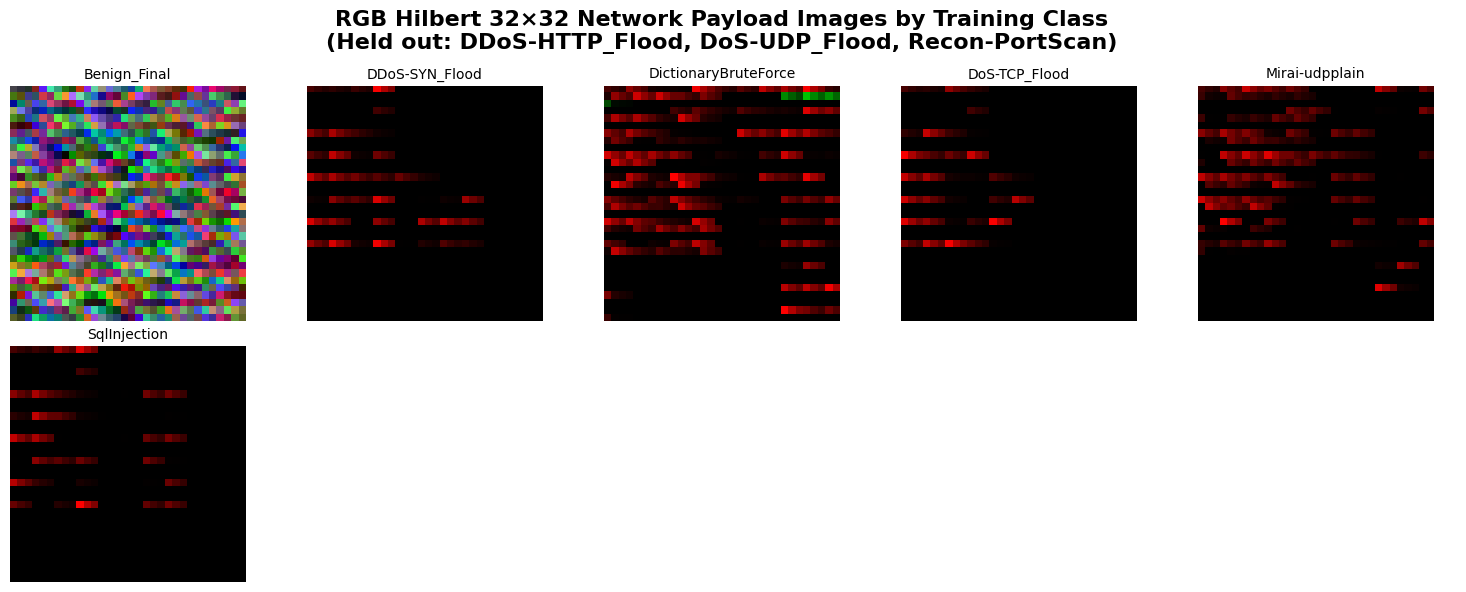


📊 Channel-wise Analysis (Training Data Only):
   Channel 1: mean=0.093, std=0.197, nonzero=0.274
   Channel 2: mean=0.062, std=0.169, nonzero=0.174
   Channel 3: mean=0.054, std=0.159, nonzero=0.149

✓ Data visualization and analysis complete!
✓ Ready for ViT model training with 3-channel RGB Hilbert input on 6 classes
✓ Few-shot testing data prepared for: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']


In [3]:
# Section 2: Data Reshaping and Visualization
# Reshape data from flat features to RGB Hilbert images
print("Reshaping training data to RGB Hilbert images...")

# Expected: (N, 3072) → (N, 3, 32, 32)
expected_features = CONFIG['channels'] * CONFIG['image_size'] ** 2
if X.shape[1] == expected_features:
    # Reshape to (N, channels, height, width)
    X_images = X.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
    print(f"✓ Reshaped to: {X_images.shape}")
else:
    print(f"⚠️ Feature count mismatch: got {X.shape[1]}, expected {expected_features}")
    # Try to adapt - take first N features if more, or pad if fewer
    if X.shape[1] > expected_features:
        X_trimmed = X[:, :expected_features]
        X_images = X_trimmed.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
        print(f"✓ Trimmed and reshaped to: {X_images.shape}")
    else:
        # Pad with zeros
        padding = np.zeros((X.shape[0], expected_features - X.shape[1]))
        X_padded = np.concatenate([X, padding], axis=1)
        X_images = X_padded.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
        print(f"✓ Padded and reshaped to: {X_images.shape}")

# Normalize images to [0, 1] if needed
if X_images.max() > 1.0:
    X_images = X_images / 255.0
    print(f"✓ Normalized to [0, 1]: [{X_images.min():.3f}, {X_images.max():.3f}]")

# Visualize sample RGB images for each TRAINING class (combined color)
num_classes = len(label_encoder.classes_)
cols = min(5, num_classes)
rows = (num_classes + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
if rows == 1 and cols == 1:
    axes = np.array([[axes]])
elif rows == 1:
    axes = axes.reshape(1, -1)
elif cols == 1:
    axes = axes.reshape(-1, 1)

print(f"\nVisualizing sample RGB images for {num_classes} TRAINING classes...")
print(f"(Held-out classes: {HELD_OUT_CLASSES} will be used for few-shot testing)")

for class_idx in range(num_classes):
    class_name = label_encoder.classes_[class_idx]
    
    # Find first sample of this class
    class_mask = y_encoded == class_idx
    sample_indices = np.where(class_mask)[0]
    
    if len(sample_indices) > 0:
        sample_idx = sample_indices[0]
        # Convert CHW → HWC for color display
        rgb_image = X_images[sample_idx].transpose(1, 2, 0)
        rgb_image = np.clip(rgb_image, 0.0, 1.0)
        r, c = divmod(class_idx, cols)
        ax = axes[r, c]
        ax.imshow(rgb_image)
        ax.set_title(f'{class_name}', fontsize=10)
        ax.axis('off')

# Hide any unused axes
for idx in range(num_classes, rows * cols):
    r, c = divmod(idx, cols)
    axes[r, c].axis('off')

plt.suptitle(f'RGB Hilbert 32×32 Network Payload Images by Training Class\n(Held out: {", ".join(HELD_OUT_CLASSES)})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze channel statistics for training data
print(f"\n📊 Channel-wise Analysis (Training Data Only):")
for channel in range(CONFIG['channels']):
    channel_data = X_images[:, channel, :, :]
    mean_intensity = np.mean(channel_data)
    std_intensity = np.std(channel_data)
    nonzero_ratio = np.mean(channel_data > 0)
    print(f"   Channel {channel+1}: mean={mean_intensity:.3f}, std={std_intensity:.3f}, nonzero={nonzero_ratio:.3f}")

print(f"\n✓ Data visualization and analysis complete!")
print(f"✓ Ready for ViT model training with {CONFIG['channels']}-channel RGB Hilbert input on {CONFIG['num_classes']} classes")
print(f"✓ Few-shot testing data prepared for: {HELD_OUT_CLASSES}")


🖼️ Visualizing held-out classes (few-shot set)...


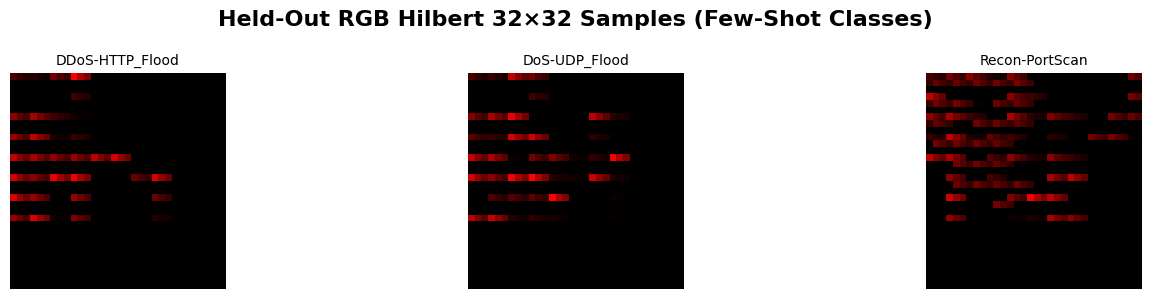

In [4]:
# Section 2b: Visualization of Held-Out Classes (Few-Shot)
if X_held_out is not None and len(X_held_out) > 0:
    print("\n🖼️ Visualizing held-out classes (few-shot set)...")
    
    # Reshape and normalize held-out images
    X_held_out_images = X_held_out.reshape(
        -1,
        CONFIG['channels'],
        CONFIG['image_size'],
        CONFIG['image_size']
    )
    if X_held_out_images.max() > 1.0:
        X_held_out_images = X_held_out_images / 255.0
    
    unique_held_out_classes = np.unique(y_held_out)
    cols = min(5, len(unique_held_out_classes))
    rows = (len(unique_held_out_classes) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    for i, class_name in enumerate(unique_held_out_classes):
        indices = np.where(y_held_out == class_name)[0]
        if len(indices) == 0:
            continue
        sample_idx = indices[0]
        rgb_image = X_held_out_images[sample_idx].transpose(1, 2, 0)
        rgb_image = np.clip(rgb_image, 0.0, 1.0)
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.imshow(rgb_image)
        ax.set_title(f'{class_name}', fontsize=10)
        ax.axis('off')

    # Hide unused axes
    for j in range(len(unique_held_out_classes), rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis('off')

    plt.suptitle('Held-Out RGB Hilbert 32×32 Samples (Few-Shot Classes)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No held-out data available for visualization.")


In [5]:
# Section 3: Multi-Channel Vision Transformer Architecture
class MultiChannelPatchEmbedding(nn.Module):
    """Convert multi-channel images to patch embeddings"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (img_size // patch_size) ** 2
        
        # Convolutional layer to extract patches from multi-channel input
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x shape: (batch_size, in_channels, img_size, img_size)
        x = self.projection(x)  # (batch_size, embed_dim, H', W')
        x = x.flatten(2)        # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)   # (batch_size, num_patches, embed_dim)
        return x

class MultiChannelVisionTransformer(nn.Module):
    """Vision Transformer for Multi-Channel Network Payload Classification"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()
        
        # Multi-channel patch embedding
        self.patch_embedding = MultiChannelPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embedding.num_patches
        
        # Learnable position embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        
        # Class token (for classification)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Convert to patches and embed
        x = self.patch_embedding(x)  # (batch_size, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Pass through transformer
        x = self.transformer(x)
        
        # Classification from class token
        cls_output = x[:, 0]  # Take the class token
        cls_output = self.norm(cls_output)
        output = self.head(cls_output)
        
        return output

# Initialize the Multi-Channel Vision Transformer
model = MultiChannelVisionTransformer(
    img_size=CONFIG['image_size'],
    patch_size=CONFIG['patch_size'],
    in_channels=CONFIG['channels'],
    embed_dim=CONFIG['embed_dim'],
    num_heads=CONFIG['num_heads'],
    num_layers=CONFIG['num_layers'],
    num_classes=CONFIG['num_classes']
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🤖 Multi-Channel Vision Transformer Model:")
print(f"✓ Input: {CONFIG['channels']}-channel {CONFIG['image_size']}×{CONFIG['image_size']} images")
print(f"✓ Patches per image: {(CONFIG['image_size']//CONFIG['patch_size'])**2}")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")
print(f"✓ Model size: {total_params * 4 / 1024**2:.1f} MB")

# Test forward pass
sample_input = torch.randn(2, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size']).to(device)
with torch.no_grad():
    sample_output = model(sample_input)
    print(f"✓ Forward pass test: {sample_input.shape} → {sample_output.shape}")

print(f"\n✓ Multi-channel ViT architecture ready!")
print(f"✓ Configured for {CONFIG['num_classes']} classes: {label_encoder.classes_}")

🤖 Multi-Channel Vision Transformer Model:
✓ Input: 3-channel 32×32 images
✓ Patches per image: 4
✓ Total parameters: 4,939,014
✓ Trainable parameters: 4,939,014
✓ Model size: 18.8 MB
✓ Forward pass test: torch.Size([2, 3, 32, 32]) → torch.Size([2, 6])

✓ Multi-channel ViT architecture ready!
✓ Configured for 6 classes: ['Benign_Final' 'DDoS-SYN_Flood' 'DictionaryBruteForce' 'DoS-TCP_Flood'
 'Mirai-udpplain' 'SqlInjection']


Preparing training pipeline for 6-class model...
✓ Tensor conversion: X=torch.Size([72000, 3, 32, 32]), y=torch.Size([72000])
✓ Training on 6 classes: ['Benign_Final' 'DDoS-SYN_Flood' 'DictionaryBruteForce' 'DoS-TCP_Flood'
 'Mirai-udpplain' 'SqlInjection']
✓ Held-out classes for few-shot testing: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
✓ Data splits (6 training classes only):
   Train: 50400 samples
   Val:   10800 samples
   Test:  10800 samples
✓ Class weights for 6 classes: [1. 1. 1. 1. 1. 1.]
✓ Data loaders: 1575 train, 338 val, 338 test batches
✓ Training setup complete for 6-class model

🚀 Starting 6-Class ViT training for 30 epochs...
📝 Training classes: [np.str_('Benign_Final'), np.str_('DDoS-SYN_Flood'), np.str_('DictionaryBruteForce'), np.str_('DoS-TCP_Flood'), np.str_('Mirai-udpplain'), np.str_('SqlInjection')]
🔄 Held-out classes: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
Epoch  1/30: Train Loss: 0.9908, Train Acc: 58.91% | Val Loss: 0.7660, Val A

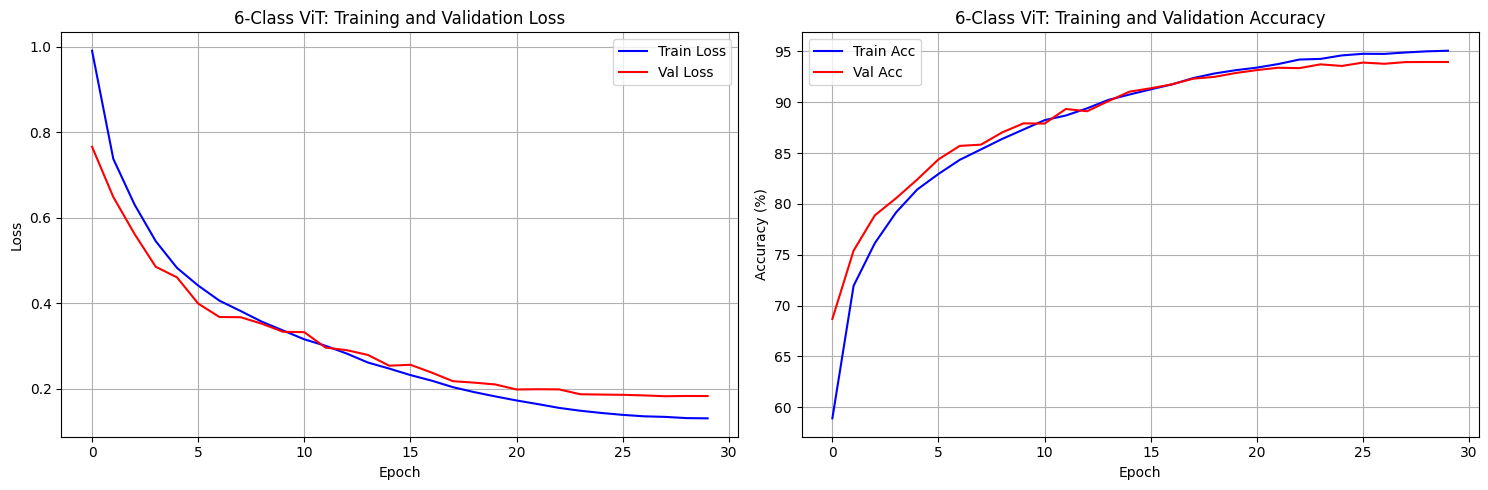


✓ 6-Class ViT training complete!
✓ Model ready for evaluation on 6 training classes
✓ Held-out data ready for few-shot testing: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']


In [6]:
# Section 4: Training Pipeline
print("Preparing training pipeline for 6-class model...")

# Convert to PyTorch tensors (training data only)
X_tensor = torch.FloatTensor(X_images)
y_tensor = torch.LongTensor(y_encoded)

print(f"✓ Tensor conversion: X={X_tensor.shape}, y={y_tensor.shape}")
print(f"✓ Training on {CONFIG['num_classes']} classes: {label_encoder.classes_}")
print(f"✓ Held-out classes for few-shot testing: {HELD_OUT_CLASSES}")

# Stratified train/validation/test split for training classes only
X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, y_tensor, test_size=0.3, stratify=y_tensor, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"✓ Data splits (6 training classes only):")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Val:   {X_val.shape[0]} samples")
print(f"   Test:  {X_test.shape[0]} samples")

# Calculate class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train.numpy()
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"✓ Class weights for 6 classes: {class_weights}")

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"✓ Data loaders: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")

# Training setup
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])

print(f"✓ Training setup complete for 6-class model")

# Training functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Training loop
print(f"\n🚀 Starting 6-Class ViT training for {CONFIG['epochs']} epochs...")
print(f"📝 Training classes: {list(label_encoder.classes_)}")
print(f"🔄 Held-out classes: {HELD_OUT_CLASSES}")
print("=" * 80)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0
patience = 5
patience_counter = 0

for epoch in range(CONFIG['epochs']):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_6class_vit_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print("=" * 80)
print(f"✓ 6-Class training completed!")
print(f"✓ Best validation accuracy: {best_val_acc:.2f}%")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_title('6-Class ViT: Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc', color='blue')
ax2.plot(val_accuracies, label='Val Acc', color='red')
ax2.set_title('6-Class ViT: Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\n✓ 6-Class ViT training complete!")
print(f"✓ Model ready for evaluation on 6 training classes")
print(f"✓ Held-out data ready for few-shot testing: {HELD_OUT_CLASSES}")

🔍 6-Class ViT Evaluation and Few-Shot Testing
📊 Part 1: Evaluation on 6 Training Classes
------------------------------------------------------------
🎯 6-Class ViT Test Results:
✓ Test Accuracy: 93.81%
✓ Test Loss: 0.1870
✓ Samples evaluated: 10,800

📊 Per-Class Performance (Training Classes):
------------------------------------------------------------

📈 Overall Metrics (Training Classes):
✓ Macro Avg: Precision=0.942, Recall=0.938, F1=0.939
✓ Weighted Avg: Precision=0.942, Recall=0.938, F1=0.939


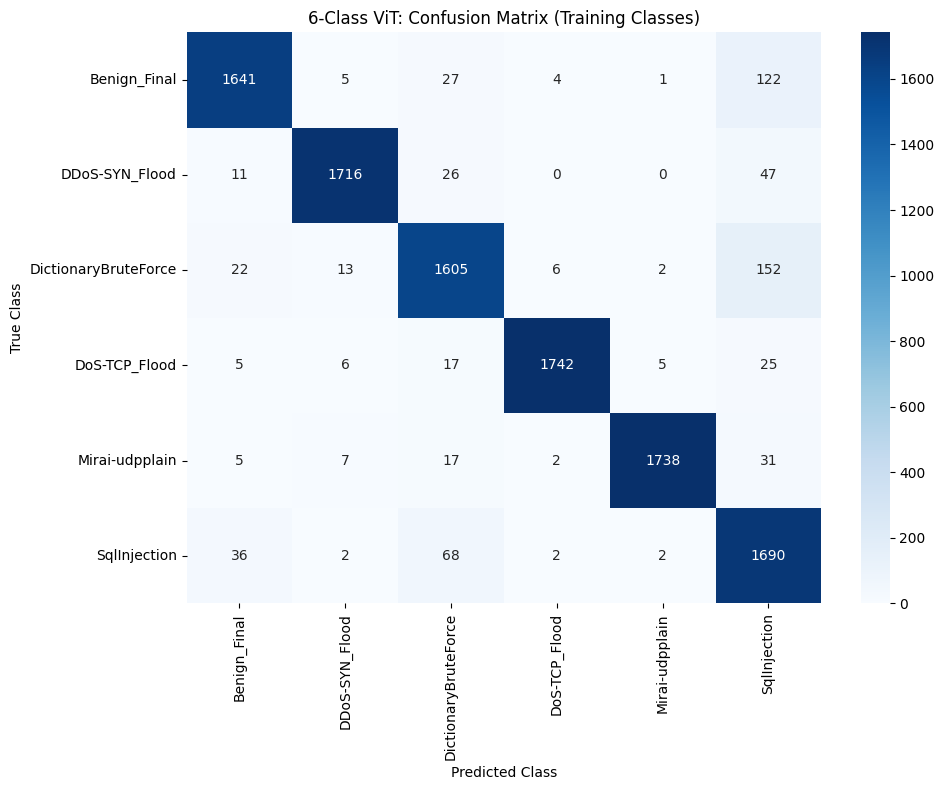


📊 Part 2: Few-Shot Testing on Held-Out Classes
🔬 Few-shot testing on: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
🔧 Extracting features from held-out data...
✓ Extracted features shape: torch.Size([36000, 256])


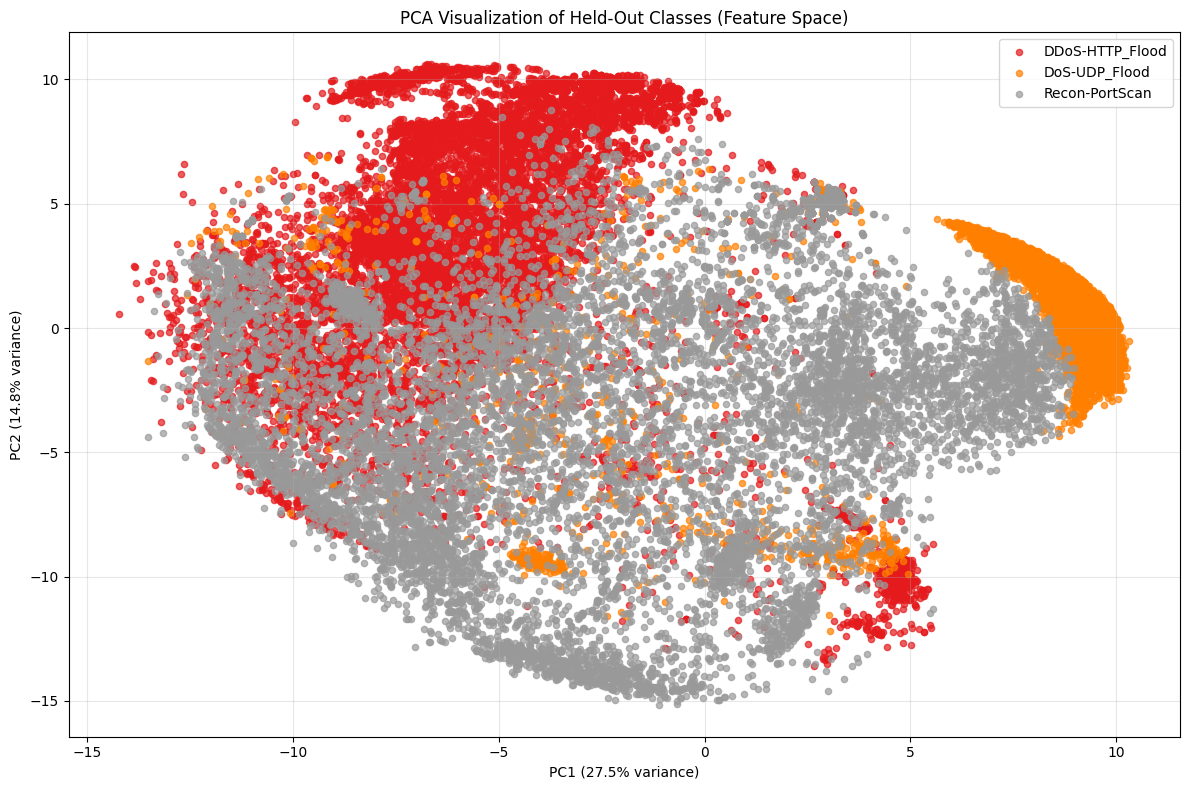


🔍 Few-Shot Clustering Analysis:
✓ Adjusted Rand Index: 0.466
✓ Silhouette Score: 0.276

📊 Held-Out Class Statistics:
   DDoS-HTTP_Flood: 12,000 samples
   DoS-UDP_Flood: 12,000 samples
   Recon-PortScan: 12,000 samples

💡 Few-Shot Testing Results:
✓ Held-out classes: 3
✓ Total held-out samples: 36,000
✓ Feature separability (ARI): 0.466
✓ Cluster quality (Silhouette): 0.276

💡 Final Results Summary:
✓ 6-Class model accuracy: 93.81%
✓ Training classes: [np.str_('Benign_Final'), np.str_('DDoS-SYN_Flood'), np.str_('DictionaryBruteForce'), np.str_('DoS-TCP_Flood'), np.str_('Mirai-udpplain'), np.str_('SqlInjection')]
✓ Held-out classes: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
✓ Model complexity: 4,939,014 parameters
✓ Input format: 3-channel 32×32 images
✓ Few-shot separability: 0.466 ARI, 0.276 Silhouette

✓ Results saved to results_6class_few_shot.json
✓ 6-Class ViT evaluation and few-shot testing complete!
✓ Model ready for few-shot learning experiments on held-out classe

In [7]:
# Section 5: Evaluation & Few-Shot Testing
print("🔍 6-Class ViT Evaluation and Few-Shot Testing")
print("=" * 80)

# Load best model
model.load_state_dict(torch.load('best_6class_vit_model.pth'))
model.eval()

# Comprehensive evaluation function
def evaluate_model(model, dataloader, device, class_names=None):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            loss = criterion(output, target)
            test_loss += loss.item()
            
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(dataloader)
    
    return accuracy, avg_loss, np.array(all_predictions), np.array(all_targets)

# 1. Evaluate on 6 training classes
print("📊 Part 1: Evaluation on 6 Training Classes")
print("-" * 60)

test_accuracy, test_loss, predictions, targets = evaluate_model(model, test_loader, device)

print(f"🎯 6-Class ViT Test Results:")
print(f"✓ Test Accuracy: {test_accuracy:.2f}%")
print(f"✓ Test Loss: {test_loss:.4f}")
print(f"✓ Samples evaluated: {len(targets):,}")

# Detailed classification report for training classes
class_names = label_encoder.classes_
report = classification_report(targets, predictions, target_names=class_names, output_dict=True, zero_division=0)

print(f"\n📊 Per-Class Performance (Training Classes):")
print("-" * 60)

for i, class_name in enumerate(class_names):
    if str(i) in report:
        precision = report[str(i)]['precision']
        recall = report[str(i)]['recall']
        f1 = report[str(i)]['f1-score']
        support = report[str(i)]['support']
        print(f"{class_name:15s}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support:,}")

print(f"\n📈 Overall Metrics (Training Classes):")
print(f"✓ Macro Avg: Precision={report['macro avg']['precision']:.3f}, Recall={report['macro avg']['recall']:.3f}, F1={report['macro avg']['f1-score']:.3f}")
print(f"✓ Weighted Avg: Precision={report['weighted avg']['precision']:.3f}, Recall={report['weighted avg']['recall']:.3f}, F1={report['weighted avg']['f1-score']:.3f}")

# Confusion Matrix for training classes
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('6-Class ViT: Confusion Matrix (Training Classes)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# 2. Few-Shot Testing on Held-Out Classes
print("\n" + "=" * 80)
print("📊 Part 2: Few-Shot Testing on Held-Out Classes")
print("=" * 80)

if X_held_out is not None and len(X_held_out) > 0:
    # Prepare held-out data
    print(f"🔬 Few-shot testing on: {HELD_OUT_CLASSES}")
    
    # Reshape held-out data
    X_held_out_images = X_held_out.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
    
    # Normalize if needed
    if X_held_out_images.max() > 1.0:
        X_held_out_images = X_held_out_images / 255.0
    
    # For few-shot testing, we'll use feature extraction from the pre-trained model
    # and evaluate how well the learned features can distinguish held-out classes
    
    def extract_features(model, data_tensor, device, batch_size=32):
        """Extract features from the model's penultimate layer"""
        model.eval()
        features = []
        
        with torch.no_grad():
            for i in range(0, len(data_tensor), batch_size):
                batch = data_tensor[i:i+batch_size].to(device)
                
                # Forward pass through the model (excluding final classification layer)
                x = model.patch_embedding(batch)
                
                # Add class token
                cls_tokens = model.cls_token.expand(batch.size(0), -1, -1)
                x = torch.cat((cls_tokens, x), dim=1)
                
                # Add positional embeddings
                x = x + model.pos_embedding
                x = model.dropout(x)
                
                # Pass through transformer
                x = model.transformer(x)
                
                # Extract class token features (before final classification)
                cls_output = x[:, 0]
                cls_output = model.norm(cls_output)
                
                features.append(cls_output.cpu())
        
        return torch.cat(features, dim=0)
    
    # Extract features for held-out classes
    print("🔧 Extracting features from held-out data...")
    held_out_tensor = torch.FloatTensor(X_held_out_images)
    held_out_features = extract_features(model, held_out_tensor, device)
    
    print(f"✓ Extracted features shape: {held_out_features.shape}")
    
    # Analyze feature separability for held-out classes
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    from sklearn.metrics import adjusted_rand_score, silhouette_score
    
    # PCA visualization
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(held_out_features.numpy())
    
    plt.figure(figsize=(12, 8))
    
    # Plot by actual class
    unique_held_out_classes = np.unique(y_held_out)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_held_out_classes)))
    
    for i, class_name in enumerate(unique_held_out_classes):
        mask = y_held_out == class_name
        plt.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                   c=[colors[i]], label=class_name, alpha=0.7, s=20)
    
    plt.title('PCA Visualization of Held-Out Classes (Feature Space)')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Clustering analysis
    print(f"\n🔍 Few-Shot Clustering Analysis:")
    n_clusters = len(unique_held_out_classes)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(held_out_features.numpy())
    
    # Create label encoder for held-out classes
    held_out_label_encoder = LabelEncoder()
    y_held_out_encoded = held_out_label_encoder.fit_transform(y_held_out)
    
    # Calculate clustering metrics
    ari_score = adjusted_rand_score(y_held_out_encoded, cluster_labels)
    sil_score = silhouette_score(held_out_features.numpy(), cluster_labels)
    
    print(f"✓ Adjusted Rand Index: {ari_score:.3f}")
    print(f"✓ Silhouette Score: {sil_score:.3f}")
    
    # Per-class analysis for held-out classes
    print(f"\n📊 Held-Out Class Statistics:")
    for class_name in unique_held_out_classes:
        count = np.sum(y_held_out == class_name)
        print(f"   {class_name}: {count:,} samples")
    
    print(f"\n💡 Few-Shot Testing Results:")
    print(f"✓ Held-out classes: {len(unique_held_out_classes)}")
    print(f"✓ Total held-out samples: {len(y_held_out):,}")
    print(f"✓ Feature separability (ARI): {ari_score:.3f}")
    print(f"✓ Cluster quality (Silhouette): {sil_score:.3f}")
    
else:
    print("⚠️ No held-out data available for few-shot testing")

# Performance summary
print(f"\n" + "=" * 80)
print(f"💡 Final Results Summary:")
print(f"✓ 6-Class model accuracy: {test_accuracy:.2f}%")
print(f"✓ Training classes: {list(label_encoder.classes_)}")
print(f"✓ Held-out classes: {HELD_OUT_CLASSES}")
print(f"✓ Model complexity: {total_params:,} parameters")
print(f"✓ Input format: {CONFIG['channels']}-channel {CONFIG['image_size']}×{CONFIG['image_size']} images")

if X_held_out is not None:
    print(f"✓ Few-shot separability: {ari_score:.3f} ARI, {sil_score:.3f} Silhouette")

# Save results
results_6class = {
    'model_type': '6class_32x32_few_shot',
    'training_classes': list(label_encoder.classes_),
    'held_out_classes': HELD_OUT_CLASSES,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'num_training_classes': CONFIG['num_classes'],
    'num_parameters': total_params,
    'confusion_matrix': cm.tolist(),
    'classification_report': report
}

if X_held_out is not None:
    results_6class['few_shot_metrics'] = {
        'adjusted_rand_index': ari_score,
        'silhouette_score': sil_score,
        'held_out_samples': len(y_held_out)
    }

import json
with open('results_6class_few_shot.json', 'w') as f:
    json.dump(results_6class, f, indent=2, default=str)

print(f"\n✓ Results saved to results_6class_few_shot.json")
print(f"✓ 6-Class ViT evaluation and few-shot testing complete!")
print(f"✓ Model ready for few-shot learning experiments on held-out classes")